In [67]:
import matplotlib
import numpy as np
import pandas as pd

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# https://zhuanlan.zhihu.com/p/56507515
# https://zhuanlan.zhihu.com/p/410655154
# https://zhuanlan.zhihu.com/p/21275919

In [68]:
src_path = 'indexProcessed.csv'
test_size = 0.1               # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 2                        # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14

In [69]:
df = pd.read_csv(src_path, sep = ",")
# df = df.drop(df.columns[[0]], axis = 1)
del df['Index']
display(df)

,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013
...,...,...,...,...,...,...,...,...
104219,2021-05-25,66054.921880,66812.453130,66022.976560,66076.679690,66076.679690,0.0,4625.367578
104220,2021-05-26,66076.679690,66446.367190,66030.351560,66108.226560,66108.226560,0.0,4627.575859
104221,2021-05-27,66108.226560,66940.250000,66102.546880,66940.250000,66940.250000,0.0,4685.817500
104222,2021-05-28,66940.250000,67726.562500,66794.609380,67554.859380,67554.859380,0.0,4728.840157


In [70]:
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

/tmp/ipykernel_521017/2103356123.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')


,date,open,high,low,close,adj_close,volume,closeusd,month
40920,1965-01-05,1257.719971,1257.719971,1257.719971,1257.719971,1257.719971,0.0,12.577200,1
40921,1965-01-06,1263.989990,1263.989990,1263.989990,1263.989990,1263.989990,0.0,12.639900,1
40922,1965-01-07,1274.270020,1274.270020,1274.270020,1274.270020,1274.270020,0.0,12.742700,1
40923,1965-01-08,1286.430054,1286.430054,1286.430054,1286.430054,1286.430054,0.0,12.864301,1
40924,1965-01-12,1288.540039,1288.540039,1288.540039,1288.540039,1288.540039,0.0,12.885400,1
40925,1965-01-13,1281.670044,1281.670044,1281.670044,1281.670044,1281.670044,0.0,12.816700,1
40926,1965-01-14,1289.500000,1289.500000,1289.500000,1289.500000,1289.500000,0.0,12.895000,1
40927,1965-01-18,1271.680054,1271.680054,1271.680054,1271.680054,1271.680054,0.0,12.716801,1
40928,1965-01-19,1270.339966,1270.339966,1270.339966,1270.339966,1270.339966,0.0,12.703400,1
40929,1965-01-20,1268.880005,1268.880005,1268.880005,1268.880005,1268.880005,0.0,12.688800,1


Text(0.5, 0, 'date')

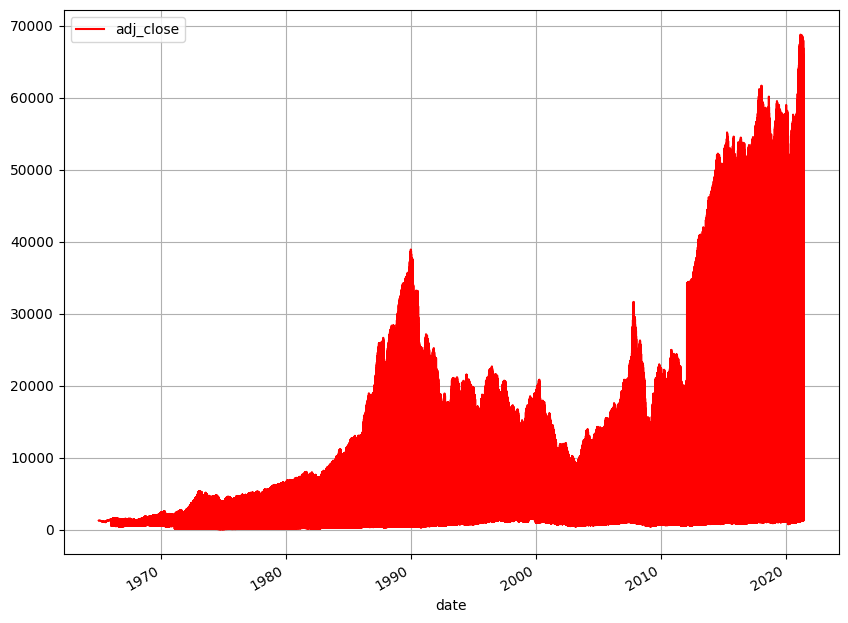

In [71]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x = 'date', y = 'adj_close', style = 'r-', grid = True)
ax.set_xlabel("date")
# df.plot(x = 'date', y = 'adj_close', marker = ',', markevery = 10, color = 'r', ls = '-', lw = 2)

In [72]:
# Get sizes of each of the datasets
num_cv, num_test = int(cv_size*len(df)), int(test_size*len(df))
num_train = len(df) - num_test

print("total_num = " + str(len(df)) )
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train: num_train + num_cv]
train_cv = df[:num_train + num_cv]
test = df[num_train + num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

total_num = 104224
num_train = 93802
num_cv = 20844
num_test = 10422
train.shape = (93802, 9)
cv.shape = (10422, 9)
train_cv.shape = (104224, 9)
test.shape = (0, 9)


Text(0, 0.5, 'USD')

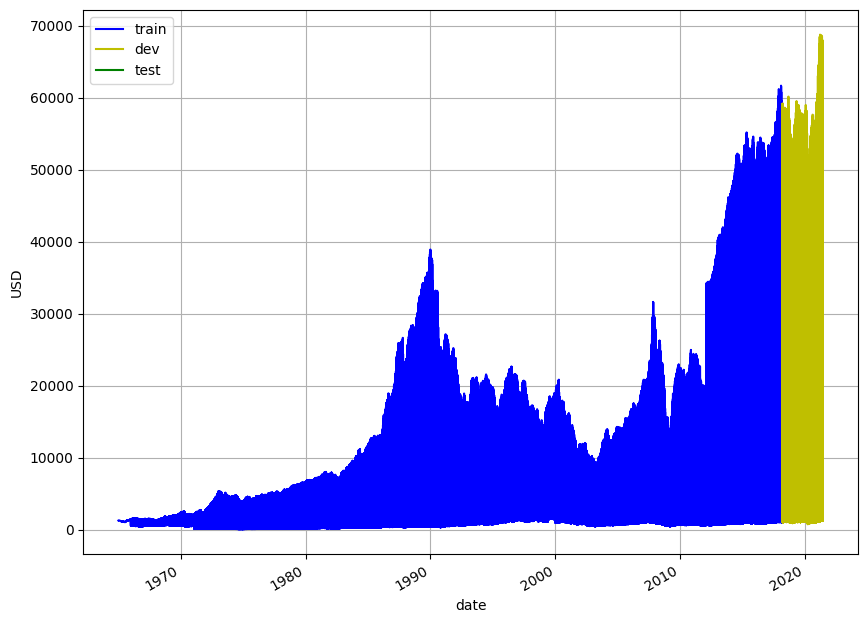

In [73]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x = 'date', y = 'adj_close', style = 'b-', grid = True)
ax = cv.plot(x = 'date', y = 'adj_close', style = 'y-', grid = True, ax = ax)
ax = test.plot(x = 'date', y = 'adj_close', style = 'g-', grid = True, ax = ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [74]:
# X_train,Y_train = df['date'][:num_train], df['adj_close'][:num_train]
# X_test,Y_test = df['date'][num_train:], df['adj_close'][num_train:]
X_train, Y_train = df[:num_train], df[:num_train].adj_close
X_test, Y_test = df[num_train:], df[num_train:].adj_close

In [75]:
print(X_train)

            date          open          high           low         close  \
40920 1965-01-05   1257.719971   1257.719971   1257.719971   1257.719971   
40921 1965-01-06   1263.989990   1263.989990   1263.989990   1263.989990   
40922 1965-01-07   1274.270020   1274.270020   1274.270020   1274.270020   
40923 1965-01-08   1286.430054   1286.430054   1286.430054   1286.430054   
40924 1965-01-12   1288.540039   1288.540039   1288.540039   1288.540039   
...          ...           ...           ...           ...           ...   
54004 2018-03-06  21390.199220  21551.140630  21381.419920  21417.759770   
40135 2018-03-06   3266.487061   3290.252930   3243.654053   3289.642090   
59440 2018-03-06   1013.059998   1015.900024   1009.239990   1009.250000   
65241 2018-03-06  10909.280270  11007.950200  10873.849610  11007.950200   
7695  2018-03-06  30380.960940  30620.060550  30129.800780  30510.730470   

          adj_close        volume     closeusd  month  
40920   1257.719971  0.000000e+

In [76]:
print(Y_train)

40920     1257.719971
40921     1263.989990
40922     1274.270020
40923     1286.430054
40924     1288.540039
             ...     
54004    21417.759770
40135     3289.642090
59440     1009.250000
65241    11007.907230
7695     30510.730470
Name: adj_close, Length: 93802, dtype: float64


In [77]:
X_train = X_train.drop(index = 85883)
Y_train = Y_train.drop(index = 40920)
# X_test = X_test.drop(index = 54793)
# Y_test = Y_test.drop(index = 101091)

In [78]:
date_val = X_test['date']

# #del X_train['adj_close']
# del X_train['date']
# del X_train['closeusd']
# #del X_test['adj_close']
# del X_test['date']
# del X_test['closeusd']

X_train = X_train[['high', 'low', 'adj_close', 'volume']]
X_test = X_test[['high', 'low', 'adj_close', 'volume']]
# X_train = X_train['open'].values.reshape(-1, 1)
# X_test = X_test['open'].values.reshape(-1, 1)

# print(Y_train)

mean = Y_train.mean()
print(mean)
Y_train = Y_train.fillna(mean, inplace=False) 

mean = X_train.mean()
X_train = X_train.fillna(mean, inplace=False) 

# mean = X_test.mean()
# X_test = X_test.fillna(mean, inplace=False) 

# mean = Y_test.mean()
# Y_test = Y_test.fillna(mean, inplace=False) 
# # X_train = X_train.values.reshape(-1, 1)

# print(X_train, Y_train)
# print(X_test, Y_test)

7143.061624366659


In [79]:
# from sklearn import linear_model
# reg = linear_model.Ridge(alpha=.5)
# # score = get_score(X_train, y_train)
# reg.fit(X_train, Y_train)
# reg.coef_
# reg.intercept_

from sklearn import linear_model
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)
print(regr.coef_)
print(regr.intercept_)
Y_pred = regr.predict(X_test)

[-2.80958442  2.29095462  1.16120002]
2780.0693704972127


In [80]:
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score, median_absolute_error

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))
print("explained_variance_score: %.2f" % explained_variance_score(Y_test, Y_pred))
mae = median_absolute_error(Y_test, Y_pred)
print("Mae: %.2f" % mae)

from sklearn.model_selection import cross_val_score
scores = cross_val_score(regr, X_test, Y_test, cv=5)
print(scores)

Coefficients: 
 [-2.80958442  2.29095462  1.16120002]
Mean squared error: 41029189.60
Coefficient of determination: 0.78
explained_variance_score: 0.84
Mae: 2220.22
[1. 1. 1. 1. 1.]


[ 9542.09124456  7380.30481218 12545.42720482 ... 20347.424339
  3579.45582951 20763.6665443 ]
101091    10784.339840
34314      7372.009766
75741     15545.200200
87524     12113.870120
101092    10745.320310
              ...     
66026     15034.780270
66027     14857.910160
54792     28946.140630
60267      1263.619995
54793     29058.109380
Name: adj_close, Length: 10422, dtype: float64


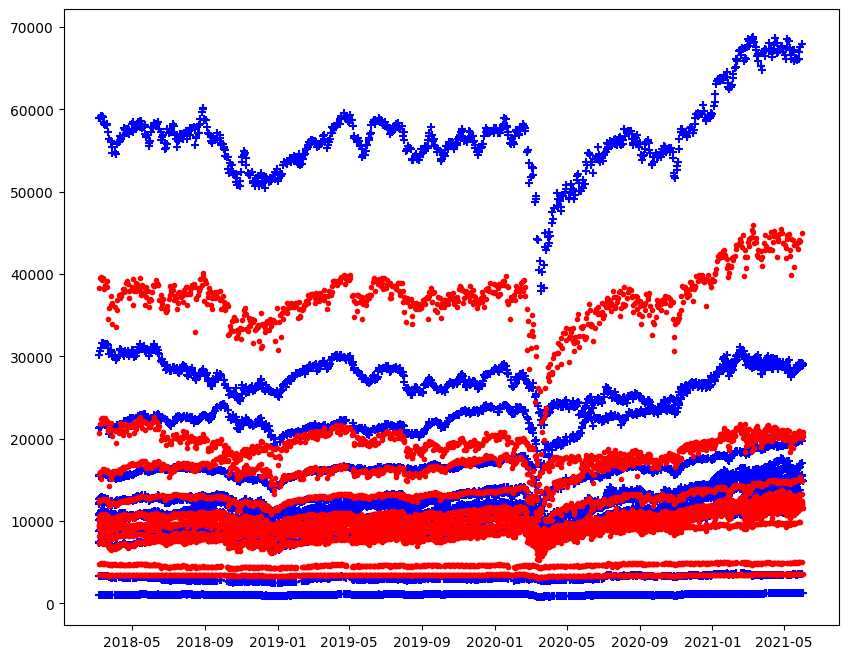

In [81]:
print(Y_pred)
print(Y_test)
ax = plt.scatter(date_val, Y_test, color="blue", marker = '+')
bx = plt.scatter(date_val, Y_pred, color="red", marker = '.')
plt.show()

In [82]:
times = 0
diff = 0
for i in Y_test:
    if int(i) != int(Y_pred[times]):
        print("different", i, Y_pred[times])
        if (int(i) - int(Y_pred[times]) >= 1):
            diff += 1
            # print("different", i, Y_pred[times])
    times += 1
print(diff, "%.2f%%" % (diff / len(Y_pred)))

different 10784.33984 9542.09124455858
different 7372.009766 7380.304812178376
different 15545.2002 12545.427204817366
different 12113.87012 10146.609367994353
different 10745.32031 9480.35249531432
different 8784.839844 8209.848843142721
different 30196.91992 20663.72293099935
different 15472.59961 12328.632791507896
different 12707.00977 10657.984113119255
different 58962.64844 38338.28230706406
different 21252.7207 15670.073457100752
different 10904.94727 9414.880090308936
different 10154.2002 9025.401725698786
different 7396.649902 7318.351283392685
different 1012.669983 3402.6571910202865
different 12245.36035 10048.466247077755
different 3271.667969 4763.310276230274
different 10242.65039 9063.363767037423
different 12355.57031 10234.373302142803
different 30654.51953 21764.907144058066
different 15538.7002 12585.921105943973
different 8896.419922 8245.592594028512
different 1026.140015 3402.500556636629
different 10823.24023 9573.281428427079
different 12745.00977 10777.03778150